In [1]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
#import stanford_mir; stanford_mir.init()
import os
import time
import crepe
import numbaDTW
#from madmom.features.onsets import RNNOnsetProcessor, OnsetPeakPickingProcessor

In [2]:
def read_file(filename):
    x, sr = librosa.load(filename)
    return x, sr

def get_frequency(x, sr):
    time, frequency, confidence, activation = crepe.predict(x, sr, viterbi=True, model_capacity='tiny',step_size=10)
    # viterbi:temporal smoothing to the pitch curve, model capacity:computation speed, step size:calculate pitch for every 10 milliseconds.
    return frequency

def get_midi(freq): #t5afef ldifferences (range ...A,)
    midi = librosa.core.hz_to_midi(freq)
    return midi

In [3]:
def get_novelty(track):
    hop_length = 512
    frame_length = 2048
    rmse = librosa.feature.rmse(track, frame_length=frame_length, hop_length=hop_length).flatten()
    return  rmse


In [4]:
def moving_average(x):
    y=numpy.zeros_like(x)
    for i,_ in enumerate(x):
        y[i]=numpy.average(x[max(0,i-20):min(len(x)-1,i+20)])
    return y 

In [5]:
def get_feature(filename):
    x, sr = read_file(filename)
    frequency = get_frequency(x, sr)
    midi = get_midi(frequency)
    midi[midi<0] = 0
    midi = numpy.round(midi, 0)
    return midi
    #return frequency

def median_filter(x, r):
    result = numpy.zeros_like(x)
    for i in range(len(x)):
        result[i] = numpy.median(x[max(i-r,0):min(i+r, len(x)-1)])
    return result

In [6]:
def low_pass_filter(signal,cutoff=0.05): #after testing at whitch frequency is the noise,cutoff huwe  aya cutoff bishil
    #aktr shi noise 
   # signal = signal / (numpy.median(signal)-1)
    y = numpy.fft.rfft(signal)
    cutoff = int(cutoff * len(y))
    for i in range( cutoff, len(y) - cutoff):
        y[i] = 0
    x = numpy.fft.irfft(y)
    #plt.plot(x)
    return x 

In [7]:
def get_correlation(feature, feature_reference):
    feature = feature[40:-40]
   
    f_len = len(feature) #length of the hummed features (frames)
    r_len = len(feature_reference) #length of the reference features
    
    feature = feature - numpy.median(feature)
    
    feature = feature/numpy.linalg.norm(feature) #normalize the features
    max_result = -1
    results=[]
    
    for i in range(r_len - f_len +1):
        s_reference = feature_reference[i:i+f_len] # get a window of a reference 
        s_reference = s_reference - numpy.median(s_reference)
        s_reference = s_reference/numpy.linalg.norm(s_reference) #normalization 
        
        scalar = numpy.dot(feature, s_reference) #inner product
        result = scalar
        results.append(result)
        if result > max_result: 
            max_result = result
    
    return max_result
    #return results

def get_dtw(chroma, chroma_reference):
    #chroma = chroma[40:-40]
    #chroma = chroma / (numpy.linalg.norm(chroma))
    #chroma_reference = chroma_reference / (numpy.linalg.norm(chroma_reference))
   # chroma = chroma / (numpy.max(chroma))
   # chroma_reference = chroma_reference / (numpy.max(chroma_reference)) #nazaln lanafs mustawa lenergy lalsot 
    D = numbaDTW.distanceMatrix(chroma, chroma_reference)
    d, wp = librosa.core.dtw(C=D, subseq = True )
    
    return D, wp
   

def get_cost(D, wp):   
    return D[wp[0][0], wp[0][1]]
   
    #slope=(wp[-1][1] - wp[0][1] ) / (wp[-1][0] - wp[0][0])
    #return abs( 1 - slope)

def compare(track, reference): 
      
    track=track[20:-20]
    track=low_pass_filter(track)
    track = track / numpy.median(track)
    
    reference = low_pass_filter(reference)
    reference = reference / numpy.median(reference)
   
    D, wp = get_dtw(track, reference)
    cost = get_cost(D, wp)
   
    #cost = get_correlation(track, reference)
    #cost = max(cost)
    return cost
  
   

In [8]:
allFiles = os.listdir('Db-full-length-midi') #get the names of the files inside folder 'database'
allHums = os.listdir('Hums')

allResults = []

for i, humname in enumerate(allHums):
    print(i/len(allHums)*100, '%')
    humname =  r'Hums/' + humname #humname
    #track,_=read_file(humname)
    
    track,sr = read_file(humname)
    
    #hum = get_feature(track) #rmse
    hum = get_novelty(track)
    
    costs = numpy.zeros(len(allFiles)) #initialize the costs to zero
    results = []
    start=time.time()
    for idx, file in enumerate(allFiles): #iterate over all files in the database returns index and element 
        filename = r'Db-full-length-midi/' + file #path to each file 
        reference=numpy.load(filename)
        cost = compare(hum, reference) #compare the hummed query with the reference song
        costs[idx] = cost #put the cost in the array
        results.append([cost, file])
    end=time.time()
    print("time taken:",end-start)
    results.sort()
    
    allResults.append([humname, results])

0.0 %
time taken: 33.6828875541687
3.225806451612903 %
time taken: 18.194918870925903
6.451612903225806 %
time taken: 30.089364290237427
9.67741935483871 %
time taken: 26.751134157180786
12.903225806451612 %
time taken: 15.644106388092041
16.129032258064516 %
time taken: 29.589009284973145
19.35483870967742 %
time taken: 36.903197288513184
22.58064516129032 %
time taken: 42.233986377716064
25.806451612903224 %
time taken: 18.225522994995117
29.03225806451613 %
time taken: 21.57930088043213
32.25806451612903 %
time taken: 30.221453428268433
35.483870967741936 %
time taken: 31.977705001831055
38.70967741935484 %
time taken: 30.444621086120605
41.935483870967744 %
time taken: 30.135396480560303
45.16129032258064 %
time taken: 27.194979906082153
48.38709677419355 %
time taken: 17.379339456558228
51.61290322580645 %
time taken: 34.07719540596008
54.83870967741935 %
time taken: 24.701515436172485
58.06451612903226 %
time taken: 25.48009204864502
61.29032258064516 %
time taken: 31.43935179710

In [9]:
allResults = numpy.array(allResults)

In [28]:
i =i+1
print(allResults[i][0])
for j, r in enumerate(allResults[i][1]):
    print(j,r)

Hums/hussein.la.vie.en.rose.wav
0 [0.078882817485545, 'Gnash ft  Olivia Obrien - I Hate U I Love U piano cover and lyrics by Betty Nguyen.wav.npy']
1 [0.09377250743467237, 'La Vie en Rose piano José M. Armenta - Copy.wav.npy']
2 [0.24173008073579044, 'Addash kan fi nass  (Piano Solo) - قديش كان في ناس بيانو صولو - Copy.wav.npy']
3 [0.3337303932381501, 'DJ Snake ft. Justin Bieber - Let Me Love You (piano cover) (online-audio-converter.com).wav.npy']
4 [0.34845372988459006, 'Bazzi - Beautiful (Piano Cover) ft. Camila Cabello Synthesia Tutorial by LittleTranscriber - Copy.wav.npy']
5 [0.4971853049545591, 'Céline Dion Damour ou damitié cover.wav.npy']
6 [0.538105352210418, 'All Of Me - John Legend (Theatre Grand Piano Cover) - Costantino Carrara.wav.npy']
7 [0.5573814141571544, 'Jean Jacques Lafon - Le Géant de Papier - Piano (Adaptation Pascal Mencarelli).wav.npy']
8 [0.6046606607767251, 'Alan Walker - Faded Piano Cover (online-audio-converter.com).wav.npy']
9 [0.6266340594011678, 'A Thou

In [11]:
rmse = numpy.load(r'RmseMidi/Gnash ft  Olivia Obrien - I Hate U I Love U piano cover and lyrics by Betty Nguyen.wav.npy')

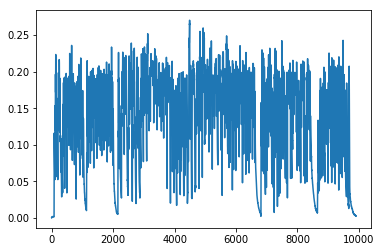

In [12]:
plt.plot(rmse)

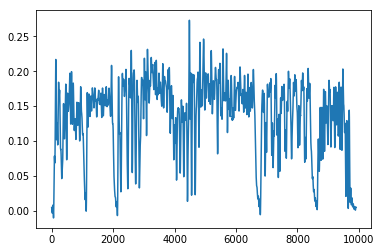

In [13]:
plt.plot(low_pass_filter(rmse))